## PREDIÇÃO DE PREÇOS

In [1]:
# Importando pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

# Configurações pro pandas mostrar números com duas casas decimais, sem notação científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

In [2]:
# Carregando a base de dados
carros = pd.read_csv("C:/Users/guisa/Projetos/Predicao_de _Precos/Data/cardekho_data.csv")
carros.head()

,Unnamed: 0,car_name,brand,model,min_cost_price,max_cost_price,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
0,0,Maruti Alto,Maruti,Alto,357003.86,465401.54,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,120000
1,1,Hyundai Grand,Hyundai,Grand,711000.00,748000.00,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,550000
2,2,Hyundai i20,Hyundai,i20,854082.87,1307925.56,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,215000
3,3,Maruti Alto,Maruti,Alto,357003.86,465401.54,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,226000
4,4,Ford Ecosport,Ford,Ecosport,1014000.00,1379000.00,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,570000


In [3]:
# Tirando a 1a coluna
carros = carros.drop(carros.columns[0], axis=1)
carros.head()

,car_name,brand,model,min_cost_price,max_cost_price,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
0,Maruti Alto,Maruti,Alto,357003.86,465401.54,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,120000
1,Hyundai Grand,Hyundai,Grand,711000.00,748000.00,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,550000
2,Hyundai i20,Hyundai,i20,854082.87,1307925.56,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,215000
3,Maruti Alto,Maruti,Alto,357003.86,465401.54,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,226000
4,Ford Ecosport,Ford,Ecosport,1014000.00,1379000.00,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,570000


In [4]:
# Observando as colunas
carros.columns

Index(['car_name', 'brand', 'model', 'min_cost_price', 'max_cost_price',
       'vehicle_age', 'km_driven', 'seller_type', 'fuel_type',
       'transmission_type', 'mileage', 'engine', 'max_power', 'seats',
       'selling_price'],
      dtype='object')

In [5]:
# Renomeando as colunas para melhor entendimento
carros.columns = ['nome', 
                  'marca', 
                  'modelo', 
                  'preco_minimo_custo', 
                  'preco_maximo_custo', 
                  'idade_veiculo', 
                  'kms_rodados', 
                  'tipo_vendedor', 
                  'tipo_combustivel',
                  'cambio',
                  'consumo', # kms por litro
                  'motor', # cilindradas
                  'potencia_maxima', # brake horse power, um tipo de cavalos de potência, mas que leva em conta a fricção
                  'assentos', 
                  'preco_venda']
carros.head()

,nome,marca,modelo,preco_minimo_custo,preco_maximo_custo,idade_veiculo,kms_rodados,tipo_vendedor,tipo_combustivel,cambio,consumo,motor,potencia_maxima,assentos,preco_venda
0,Maruti Alto,Maruti,Alto,357003.86,465401.54,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,120000
1,Hyundai Grand,Hyundai,Grand,711000.00,748000.00,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,550000
2,Hyundai i20,Hyundai,i20,854082.87,1307925.56,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,215000
3,Maruti Alto,Maruti,Alto,357003.86,465401.54,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,226000
4,Ford Ecosport,Ford,Ecosport,1014000.00,1379000.00,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,570000


In [6]:
# Renomeando os dados na coluna combustível para melhor entendimento
carros['tipo_combustivel'] = carros['tipo_combustivel'].map({'Petrol': 'Gasolina', 'Diesel': 'Diesel', 'CNG': 'GNV', 'LPG': 'GLP', 'Electric': 'Eletrico'})
carros['tipo_combustivel'].unique()

array(['Gasolina', 'Diesel', 'GNV', 'GLP', 'Eletrico'], dtype=object)

In [7]:
# Verificando o Numero de linhas e colunas
carros.shape

(15411, 15)

In [8]:
# Informacoes basicas das colunas e valores
carros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15411 entries, 0 to 15410
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nome                15411 non-null  object 
 1   marca               15411 non-null  object 
 2   modelo              15411 non-null  object 
 3   preco_minimo_custo  15411 non-null  float64
 4   preco_maximo_custo  15411 non-null  float64
 5   idade_veiculo       15411 non-null  int64  
 6   kms_rodados         15411 non-null  int64  
 7   tipo_vendedor       15411 non-null  object 
 8   tipo_combustivel    15411 non-null  object 
 9   cambio              15411 non-null  object 
 10  consumo             15411 non-null  float64
 11  motor               15411 non-null  int64  
 12  potencia_maxima     15411 non-null  float64
 13  assentos            15411 non-null  int64  
 14  preco_venda         15411 non-null  int64  
dtypes: float64(4), int64(5), object(6)
memory usage: 1.8+

In [9]:
# Avaliando valores faltantes
carros.isnull().sum()

nome                  0
marca                 0
modelo                0
preco_minimo_custo    0
preco_maximo_custo    0
idade_veiculo         0
kms_rodados           0
tipo_vendedor         0
tipo_combustivel      0
cambio                0
consumo               0
motor                 0
potencia_maxima       0
assentos              0
preco_venda           0
dtype: int64

#### Neste caso não precisamos fazer imputação de dados faltantes

### EDA
Aqui faremos uma EDA simples pra verificar possíveis correlações e entender melhor a base

In [10]:
carros.describe()

,preco_minimo_custo,preco_maximo_custo,idade_veiculo,kms_rodados,consumo,motor,potencia_maxima,assentos,preco_venda
count,15411.00,15411.00,15411.00,15411.00,15411.00,15411.00,15411.00,15411.00,15411.00
mean,5892971.12,1962623.92,6.04,55616.48,19.70,1486.06,100.59,5.33,774971.12
std,56698513.93,2889635.64,3.01,51618.55,4.17,521.11,42.97,0.81,894128.36
min,311000.00,436000.00,0.00,100.00,4.00,793.00,38.40,0.00,40000.00
25%,668000.00,872866.67,4.00,30000.00,17.00,1197.00,74.00,5.00,385000.00
50%,855000.00,1206000.00,6.00,50000.00,19.67,1248.00,88.50,5.00,556000.00
75%,1284000.00,1743000.00,8.00,70000.00,22.70,1582.00,117.30,5.00,825000.00
max,988000000.00,91100000.00,29.00,3800000.00,33.54,6592.00,626.00,9.00,39500000.00


In [11]:
# Vamoar tratar alguns outliers observados no describe. Vamos retirar alguns dados que estão acima do percentil de 90% para agilizar nosso modelo
carros['preco_venda'].describe(percentiles=[.9])['90%']

1375000.0

In [12]:
preco_percentil_90 = carros['preco_venda'].describe(percentiles=[.9])['90%']
carros.loc[carros['preco_venda'] < preco_percentil_90].describe()

,preco_minimo_custo,preco_maximo_custo,idade_veiculo,kms_rodados,consumo,motor,potencia_maxima,assentos,preco_venda
count,13864.00,13864.00,13864.00,13864.00,13864.00,13864.00,13864.00,13864.00,13864.00
mean,2700872.60,1418572.07,6.16,56369.30,20.19,1387.32,90.71,5.28,563932.48
std,31030606.97,1540938.82,3.06,53107.80,3.98,412.71,27.78,0.76,264334.16
min,311000.00,436000.00,0.00,100.00,7.81,793.00,38.40,0.00,40000.00
25%,640000.00,775000.00,4.00,30000.00,17.40,1197.00,74.00,5.00,365000.00
50%,803000.00,1133805.56,6.00,50000.00,20.14,1248.00,84.00,5.00,525000.00
75%,1061000.00,1617000.00,8.00,71000.00,22.90,1498.00,103.20,5.00,720000.00
max,747300000.00,32700000.00,29.00,3800000.00,33.54,5461.00,364.90,9.00,1370000.00


<AxesSubplot:xlabel='preco_venda', ylabel='Count'>

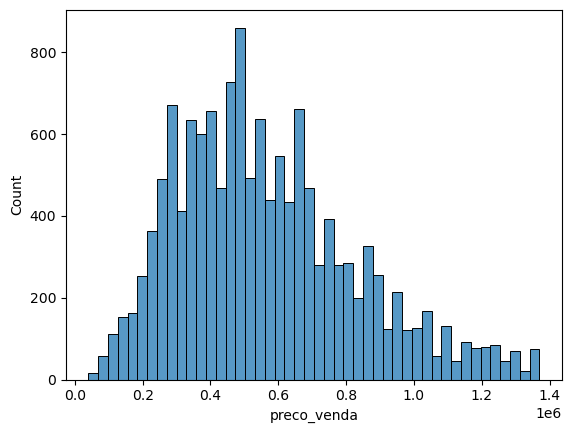

In [13]:
# Analisando graficamente os dados
sns.histplot(carros.loc[carros['preco_venda'] < preco_percentil_90, 'preco_venda'])

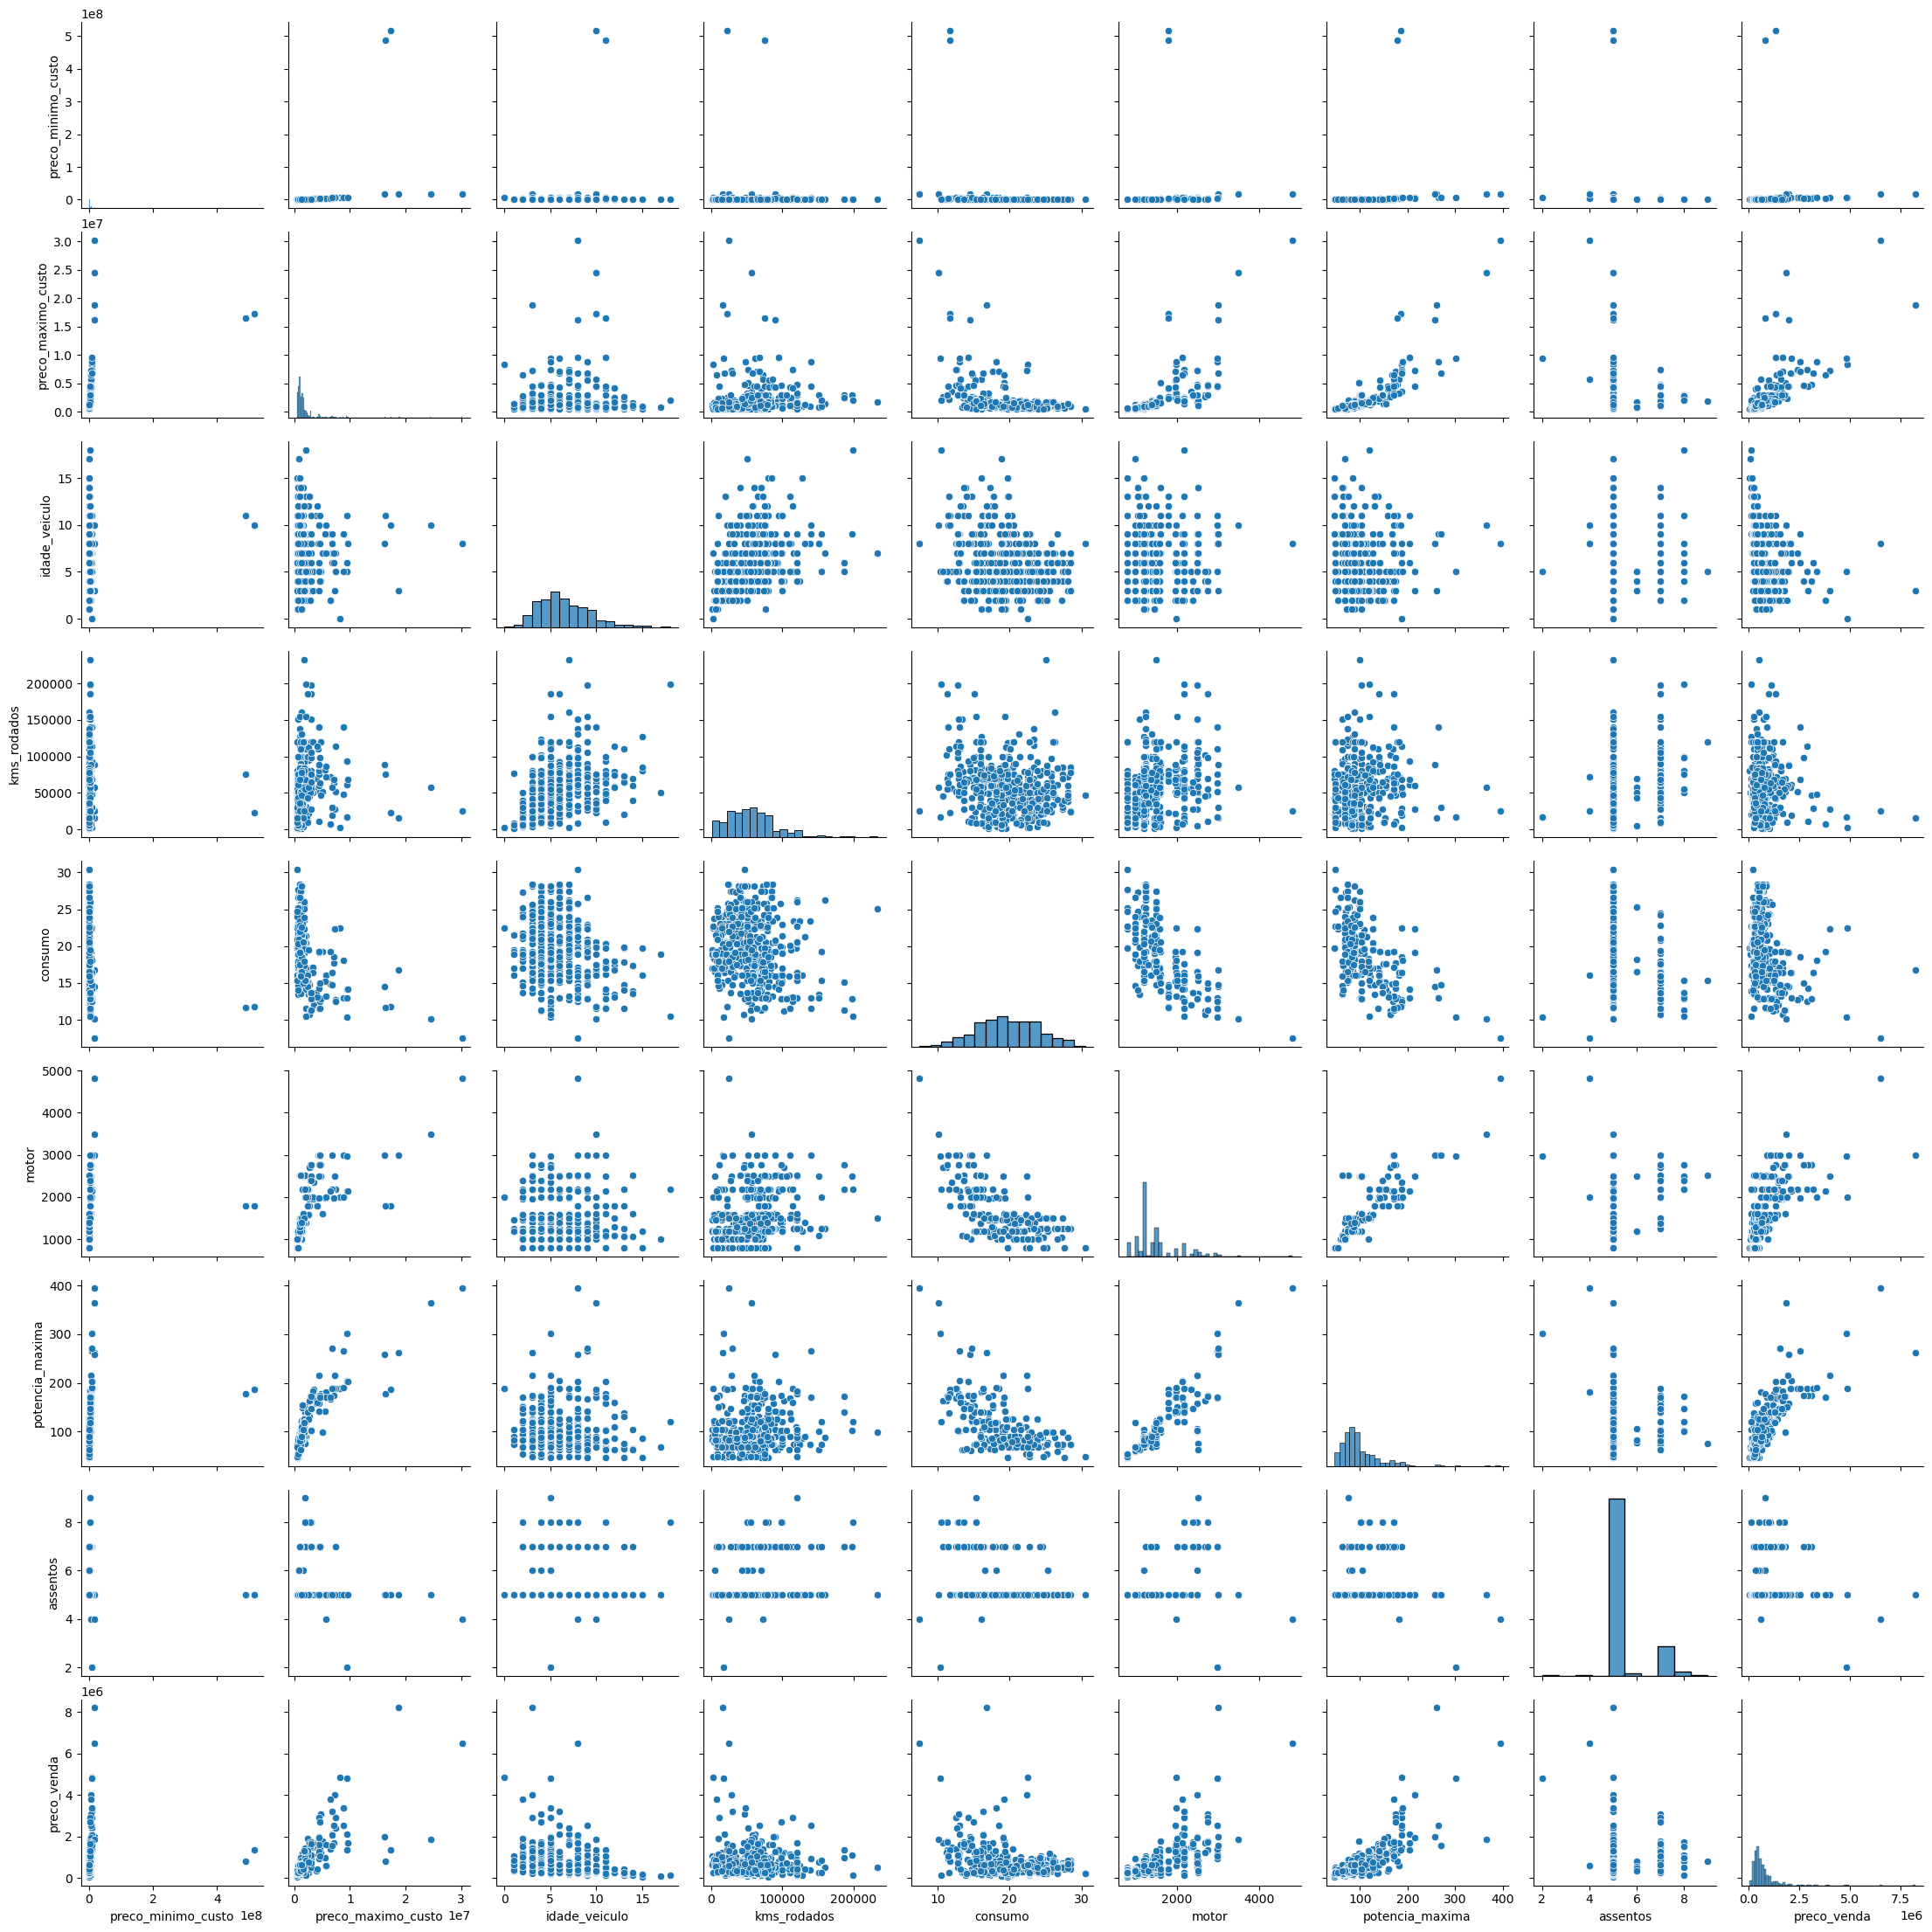

In [14]:
sns.pairplot(carros.sample(500))

## Separando variáveis preditoras e target

In [15]:
X = carros.drop(['nome','modelo','preco_venda'],axis=1)
Y = carros['preco_venda']

In [16]:
print(X)

          marca  preco_minimo_custo  preco_maximo_custo  idade_veiculo  \
0        Maruti           357003.86           465401.54              9   
1       Hyundai           711000.00           748000.00              5   
2       Hyundai           854082.87          1307925.56             11   
3        Maruti           357003.86           465401.54              9   
4          Ford          1014000.00          1379000.00              6   
...         ...                 ...                 ...            ...   
15406   Hyundai           698320.00           729333.33              9   
15407    Maruti           926776.00          1149968.00              2   
15408     Skoda           892632.65          1563551.02              6   
15409  Mahindra          1783000.00          2491000.00              5   
15410     Honda          1330978.36          1707437.40              2   

       kms_rodados tipo_vendedor tipo_combustivel     cambio  consumo  motor  \
0           120000    Individua

In [17]:
print(Y)

0         120000
1         550000
2         215000
3         226000
4         570000
          ...   
15406     250000
15407     925000
15408     425000
15409    1225000
15410    1200000
Name: preco_venda, Length: 15411, dtype: int64


## Fazendo split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=2)

## Codificar as variáveis categóricas

Usando o OneHotEncodings

In [19]:
# Buscando as colunas que não são numéricas
colunas_categoricas = X_train.select_dtypes(include=[object]).columns
colunas_categoricas

Index(['marca', 'tipo_vendedor', 'tipo_combustivel', 'cambio'], dtype='object')

In [20]:
# Criando o objeto que vai transformar nossas colunas categóricas em diversas numéricas (n-1 o número de classes)
ohe = OneHotEncoder(sparse=False, drop='first')

In [21]:
X_train['tipo_combustivel']

10937      Diesel
5370       Diesel
8136     Gasolina
13621      Diesel
11889    Gasolina
           ...   
11798      Diesel
13896    Gasolina
6637       Diesel
2575     Gasolina
7336       Diesel
Name: tipo_combustivel, Length: 13869, dtype: object

In [22]:
ohe.fit_transform(X_train[['tipo_combustivel']])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [23]:
# Transformando as variáveis categóricas em numéricas com pipeline

for coluna_categorica in colunas_categoricas:
    colunas_ohe = ohe.fit_transform(X_train[[coluna_categorica]])
    colunas_ohe_teste = ohe.transform(X_test[[coluna_categorica]])
    
    #print(ohe.categories_[0])
    
    categorias_ohe = ohe.categories_[0][1:]
    
    for indice, nome_categoria in enumerate(categorias_ohe):
        df_categorias = pd.DataFrame(data=colunas_ohe[:, indice], columns=[nome_categoria])
        df_categorias_teste = pd.DataFrame(data=colunas_ohe_teste[:, indice], columns=[nome_categoria])
        
        
        X_train[nome_categoria] = colunas_ohe[:, indice]
        X_test[nome_categoria] = colunas_ohe_teste[:, indice]
       
   
    X_train = X_train.drop(coluna_categorica, axis=1)
    X_test = X_test.drop(coluna_categorica, axis=1)

In [24]:
X_train.head()    

,preco_minimo_custo,preco_maximo_custo,idade_veiculo,kms_rodados,consumo,motor,potencia_maxima,assentos,BMW,Bentley,Datsun,Ferrari,Force,Ford,Honda,Hyundai,ISUZU,Isuzu,Jaguar,Jeep,Kia,Land Rover,Lexus,MG,Mahindra,Maruti,Maserati,Mercedes-AMG,Mercedes-Benz,Mini,Nissan,Porsche,Renault,Rolls-Royce,Skoda,Tata,Toyota,Volkswagen,Volvo,Individual,Trustmark Dealer,Eletrico,GLP,GNV,Gasolina,Manual
10937,877000.00,1137000.00,8,75000,25.80,1498,98.60,5,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
5370,978964.03,1340179.86,3,24300,28.09,1248,88.50,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
8136,357003.86,465401.54,3,5000,24.70,796,47.30,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00
13621,926776.00,1149968.00,7,35000,20.77,1248,88.76,7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
11889,853392.16,1361294.12,1,7066,18.15,998,118.35,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [25]:
carros.loc[carros.index == 10937, 'marca'].values , carros.loc[carros.index == 5370, 'marca'].values 

(array(['Honda'], dtype=object), array(['Maruti'], dtype=object))

In [26]:
X_test.head()

,preco_minimo_custo,preco_maximo_custo,idade_veiculo,kms_rodados,consumo,motor,potencia_maxima,assentos,BMW,Bentley,Datsun,Ferrari,Force,Ford,Honda,Hyundai,ISUZU,Isuzu,Jaguar,Jeep,Kia,Land Rover,Lexus,MG,Mahindra,Maruti,Maserati,Mercedes-AMG,Mercedes-Benz,Mini,Nissan,Porsche,Renault,Rolls-Royce,Skoda,Tata,Toyota,Volkswagen,Volvo,Individual,Trustmark Dealer,Eletrico,GLP,GNV,Gasolina,Manual
3313,822000.00,1362000.00,8,40000,17.00,1197,80.00,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
5442,523000.00,656000.00,5,53000,23.10,998,67.04,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1082,675762.05,990132.53,8,80000,23.40,1248,74.00,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
3498,2017158.73,2955126.98,7,86606,12.99,2494,100.60,7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
5900,698320.00,729333.33,7,70000,20.36,1197,78.90,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00


## Treinando os modelos!

### 1. Regressão linear

In [27]:
# Criando objeto de regressao linear
mdl_regressao_linear = LinearRegression()

In [28]:
mdl_regressao_linear.fit(X_train, y_train)

LinearRegression()

Validação do modelo com cross validation

In [29]:
# Validacao cruzada com r2 (quanto mais próximo de 1 melhor as variáveis preditoras explicam a variável target)
scores_regressao_linear = cross_val_score(mdl_regressao_linear, X_train, y_train, scoring='r2', cv=5)
scores_regressao_linear

array([0.73249341, 0.75030305, 0.66614506, 0.52993745, 0.7248921 ])

In [30]:
scores_regressao_linear.mean()

0.6807542142570788

### 2. Random Forest

In [31]:
# Criando objeto de random forest
mdl_random_forest = RandomForestClassifier()

In [32]:
mdl_random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
# R quadrado
scores_rf = cross_val_score(mdl_random_forest, X_train, y_train, scoring='r2', cv=5)
scores_rf

C:\Users\guisa\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.87921542, 0.90025522, 0.86705098, 0.75050141, 0.8999199 ])

In [34]:
scores_rf.mean()

0.8593885875027226

Provavelmente o modelo usando Random Forest ficou melhor porque não fizemos todos os tratamentos necessários. Mas como esse é um projeto mais simples, para aprendizado, então irei utilizar o modelo campeão Random Forest.

## Agora iremos rodar nosso modelo campeão na nossa base de teste

In [35]:
# Predições na base de teste
predicoes = mdl_random_forest.predict(X_test)

In [36]:
error_score = r2_score(y_test, predicoes)
print("R squared Error : ", error_score)

R squared Error :  0.8740506469101146


### Hora de "empacotar" pra usar na aplicação

In [37]:
import joblib

with open("C:/Users/guisa/Projetos/Predicao_de _Precos/app/models/linear_model.pkl", 'wb') as arquivo_modelo:
    joblib.dump(mdl_random_forest, arquivo_modelo,compress=3)

In [38]:
# exportar base de dados com parquet para utilizar na aplicação
carros.to_parquet("C:/Users/guisa/Projetos/Predicao_de _Precos/app/data/carros.parquet")

In [ ]:
# Rodando a aplicação
!streamlit run carros.py